## Predict 3P EoS

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
plt.rcParams.update({'font.size': 20})

2022-07-11 00:35:50.877135: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### 1. Load data from file and prepare for training

Load the EoS and the $M-R$ curves from processed data files.

In [2]:
# Load the un-normalized data.
R = np.loadtxt('../data/m-r_3p.txt')
P = np.loadtxt('../data/eos_3p.txt')

Next, normalize the data and perform a train-test-validation split as 80-15-5.

In [3]:
# Normalize the data
r = (R - np.min(R)) / (np.max(R) - np.min(R))
p = (P - np.min(P)) / (np.max(P) - np.min(P))

# Perform train-test-validation split: 80-15-5
x_tr, x_tv, y_tr, y_tv = train_test_split(r, p, test_size=0.2, random_state=41)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_tv, y_tv, test_size=0.25, random_state=41)

### 2. Build DNN Model or load model from file

Construct a deep-learning neural network (DNN). The architecture and the hyperparameters of the DNN are chosen using `keras_tuner` to optimize for performance and accuracy (see `search/random_search_3p.ipynb`). 

In [4]:
model = keras.Sequential([
    layers.Dense(194, input_shape=(97,), activation='relu'),
    layers.Dense(776, activation='relu'),
    layers.Dense(582, activation='relu'),
    layers.Dense(97, activation='linear')])
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 194)               19012     
_________________________________________________________________
dense_1 (Dense)              (None, 776)               151320    
_________________________________________________________________
dense_2 (Dense)              (None, 582)               452214    
_________________________________________________________________
dense_3 (Dense)              (None, 97)                56551     
Total params: 679,097
Trainable params: 679,097
Non-trainable params: 0
_________________________________________________________________


2022-07-11 00:35:52.641035: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-11 00:35:52.641698: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-11 00:35:52.712612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 00:35:52.712943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 with Max-Q Design computeCapability: 7.5
coreClock: 1.245GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 104.34GiB/s
2022-07-11 00:35:52.713015: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-11 00:35:52.717134: I tensorflow/stream_ex

### 3. Set up callbacks and training parameters

Set values of training parameters: batch size and number of epochs. Also, create optional callbacks such as early stopping and saving weights with checkpointings. 

In [5]:
batch_size = 512
num_epochs = 5000

# Set up a callback to stop early if given criteria is satisfied
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1.0e-10, patience=20)

# Setup checkpointing
ckpt_path = "../ckpts/eos_3p.ckpt"
ckpt_dir = os.path.dirname(ckpt_path)

# Set up another callback that saves the model's weights
save_weights = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, save_weights_only=True, verbose=0)

### 4. Fit model and save training history

Train the DNN using training and testing data. Note that we still have unobserved validation data left to be used later for further testing and predicting EoS.

In [6]:
training = model.fit(x=x_tr, y=y_tr, batch_size=batch_size, validation_data=(x_ts, y_ts), \
                    epochs=num_epochs, callbacks=[stop_early, save_weights], verbose=2)

2022-07-11 00:35:53.338486: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-11 00:35:53.358116: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/5000


2022-07-11 00:35:53.601944: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


17/17 - 1s - loss: 0.0035 - val_loss: 6.1338e-04
Epoch 2/5000
17/17 - 0s - loss: 5.6330e-04 - val_loss: 4.6353e-04
Epoch 3/5000
17/17 - 0s - loss: 4.9906e-04 - val_loss: 4.4162e-04
Epoch 4/5000
17/17 - 0s - loss: 4.7676e-04 - val_loss: 4.2105e-04
Epoch 5/5000
17/17 - 0s - loss: 4.5991e-04 - val_loss: 4.0573e-04
Epoch 6/5000
17/17 - 0s - loss: 4.4438e-04 - val_loss: 3.8987e-04
Epoch 7/5000
17/17 - 0s - loss: 4.2921e-04 - val_loss: 3.6950e-04
Epoch 8/5000
17/17 - 0s - loss: 4.3200e-04 - val_loss: 3.5494e-04
Epoch 9/5000
17/17 - 0s - loss: 4.0838e-04 - val_loss: 3.8475e-04
Epoch 10/5000
17/17 - 0s - loss: 3.9394e-04 - val_loss: 3.5616e-04
Epoch 11/5000
17/17 - 0s - loss: 4.0280e-04 - val_loss: 4.3519e-04
Epoch 12/5000
17/17 - 0s - loss: 4.2504e-04 - val_loss: 3.4111e-04
Epoch 13/5000
17/17 - 0s - loss: 3.8078e-04 - val_loss: 3.2214e-04
Epoch 14/5000
17/17 - 0s - loss: 3.6410e-04 - val_loss: 3.2904e-04
Epoch 15/5000
17/17 - 0s - loss: 3.8531e-04 - val_loss: 3.8312e-04
Epoch 16/5000
17/17 -

Epoch 124/5000
17/17 - 0s - loss: 2.4824e-04 - val_loss: 2.6087e-04
Epoch 125/5000
17/17 - 0s - loss: 2.4933e-04 - val_loss: 2.6257e-04
Epoch 126/5000
17/17 - 0s - loss: 2.6720e-04 - val_loss: 2.2394e-04
Epoch 127/5000
17/17 - 0s - loss: 2.8641e-04 - val_loss: 2.3135e-04
Epoch 128/5000
17/17 - 0s - loss: 2.8103e-04 - val_loss: 2.2886e-04
Epoch 129/5000
17/17 - 0s - loss: 2.5606e-04 - val_loss: 2.5806e-04
Epoch 130/5000
17/17 - 0s - loss: 2.6274e-04 - val_loss: 2.3089e-04
Epoch 131/5000
17/17 - 0s - loss: 2.5052e-04 - val_loss: 2.2713e-04
Epoch 132/5000
17/17 - 0s - loss: 2.4995e-04 - val_loss: 2.3194e-04
Epoch 133/5000
17/17 - 0s - loss: 2.5114e-04 - val_loss: 2.8552e-04
Epoch 134/5000
17/17 - 0s - loss: 2.5679e-04 - val_loss: 2.3955e-04
Epoch 135/5000
17/17 - 0s - loss: 2.5513e-04 - val_loss: 2.2675e-04
Epoch 136/5000
17/17 - 0s - loss: 2.4726e-04 - val_loss: 2.3393e-04
Epoch 137/5000
17/17 - 0s - loss: 2.5571e-04 - val_loss: 2.2413e-04
Epoch 138/5000
17/17 - 0s - loss: 2.5883e-04 - v

### 5. Check training results

Examine how well the network was trained by evaluating the model (i.e. computing the loss function) on the validation data and looking into the training history. Keep an eye on the order of magnitude of the loss function and any evidence of overfitting or underfitting. 

In [7]:
loss = model.evaluate(x_vl, y_vl, verbose=0)
print("Loss = {:.4e}".format(loss))

Loss = 2.1019e-04


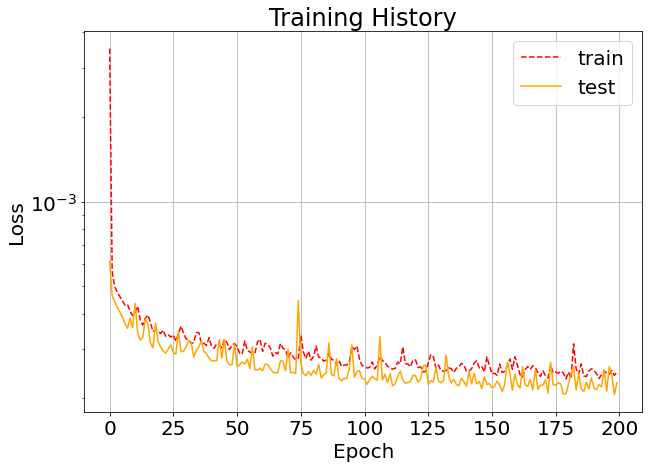

In [8]:
plt.figure(figsize=(10,7))
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()